In [1]:
import os, sys

THIS_DIR = os.path.dirname(os.path.abspath("__file__"))
PARENT_DIR = os.path.dirname(os.path.dirname(os.path.abspath("__file__")))
sys.path.append(PARENT_DIR)
import torch
import numpy as np
from sparse_integrator import Mid_point
from plots import *
from modules import *
from scipy.integrate import solve_ivp
from mpl_toolkits.mplot3d import Axes3D # <--- This is important for 3d plotting 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if device.type == "cpu":
    print("No GPU found!")
else:
    print("Great, a GPU is there")
    # get_ipython().system('nvidia-smi')
print("=" * 50)

from scipy import sparse
from scipy.sparse import spdiags
torch.set_grad_enabled(True)
np.random.seed(100)
torch.manual_seed(100)

Great, a GPU is there


## Define the parameters

In [2]:
class params:
    t_final       = 160        # Final simulation time
    Np            = 1         # Number of parameters
    Nt            = 3201       # Number of temporal nodes
    N             = 512       # Number of spatial nodes 
    L             = 10        # [-L,L] spatial domain
    h             = 2*L/N     # Spatial step size
params=params
params.h

0.0390625

## Construct the second order derivative matrices

In [3]:

e        = np.ones(params.N)
D2       = (1/params.h**2)*spdiags([e,-2*e,e], [-1,0,1], params.N, params.N)
D2       = D2.tolil()
D2[-1,0] = (1/params.h**2)
D2[0,-1] = (1/params.h**2)
D2       = D2.tocsr()


Governing equations

$$ i \dfrac{\partial u}{\partial t} + \frac{1}{2} u_{xx}+ |u|^2 u=0, $$

Setting $u=q+ i p$, we have

$$
q_t =  \frac{1}{2} p_{xx} + (q^2 + p^2)p
\\

p_t = −\frac{1}{2}q_{xx} − (q^2 + p^2)q
$$

The Hamiltonian for these equations is 
 $$ 
H(u) = \dfrac{1}{2}\int_{\Omega} \bigg[
    \bigg(\dfrac{\partial q}{\partial x}\bigg)^2+
    \bigg(\dfrac{\partial p}{\partial x}\bigg)^2-
    \dfrac{1}{2} (q^2+p^2)^2
    \bigg]\,dx
 $$

In [4]:
beta = 1.0
alpha = 0.5
def nls(t, z):
    len_z = len(z)
    q, p  = z[: len_z // 2], z[len_z // 2 :]
    dqdt  =  alpha*D2*p + beta*(q**2+p**2)*p 
    dpdt  = -alpha*D2*q - beta*(q**2+p**2)*q 
    dzdt  = np.concatenate((dqdt, dpdt), axis=0)
    return dzdt

In [5]:
def nls_jacobian( z):
    len_z = len(z)
    q, p  =  z[: len_z // 2], z[len_z // 2 :]
    q     =  q.squeeze()
    p     =  p.squeeze() 
    R1q   =  2*spdiags(p*q,0,params.N,params.N) 
    R1p   =  0.5*D2 + spdiags(q**2,0,params.N,params.N)+3*spdiags(p**2,0,params.N,params.N)
    R1    =  sparse.hstack((R1q,R1p))
    R2q   = -0.5*D2 - spdiags(p**2,0,params.N,params.N)-3*spdiags(q**2,0,params.N,params.N) 
    R2p   = -2*spdiags(p*q,0,params.N,params.N) 
    R2    =  sparse.hstack((R2q,R2p))
    J     =  sparse.vstack((R1,R2))
    return J

In [6]:
t_train   = np.linspace(0,params.t_final,params.Nt).T
t_train   = t_train.squeeze()
x         = np.linspace(-params.L,params.L,params.N)
[X,T]     = np.meshgrid(x,t_train)

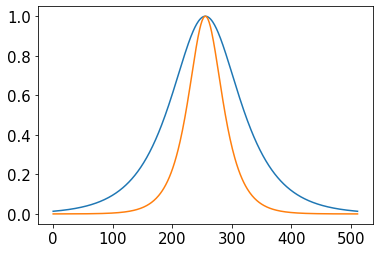

In [7]:
phi1              = 1/np.cosh( x/2 )
phi2              = 1/np.cosh( x )
plt.plot(np.real(phi1))
plt.plot(np.real(phi2))

In [8]:
sol_train=np.zeros((params.Np,2*params.N,params.Nt))
for i in range(params.Np):
    phi              = 1/np.cosh( x/2 )
    y0               = np.concatenate((np.real(phi), np.imag(phi)), axis=0).reshape(-1,1)
    sol_train[i,:,:] = Mid_point(nls,nls_jacobian,y0,t_train)

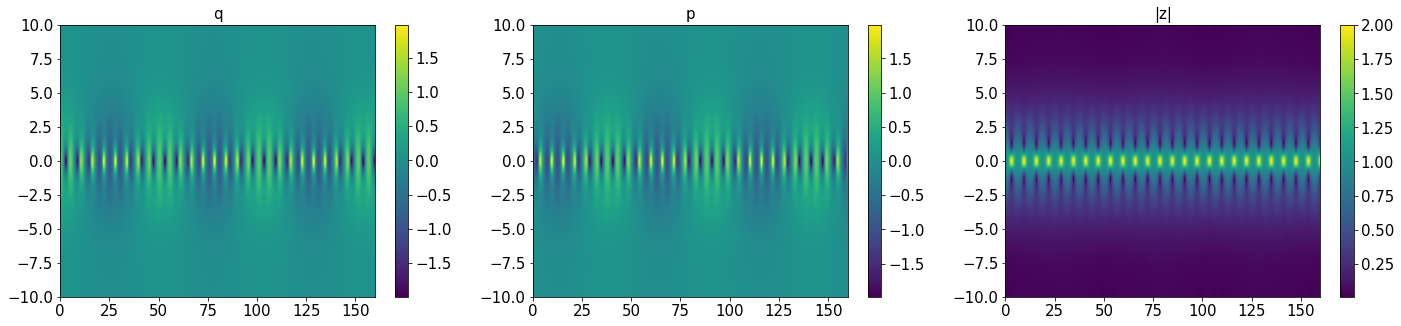

In [9]:
fig     = plt.figure(figsize=(24, 5))
for i in range(params.Np):
    q, p    = sol_train[i,:params.N,:], sol_train[i,params.N:,:]
    abs_phi = np.sqrt(q**2+p**2)
    plt.subplot(params.Np,3,3*i+1)
    plt.pcolormesh(T,X,q.T)
    plt.colorbar()
    plt.title('q')
    plt.subplot(params.Np,3,3*i+2)
    plt.pcolormesh(T,X,p.T)
    plt.colorbar()
    plt.title('p')
    plt.subplot(params.Np,3,3*i+3)
    plt.pcolormesh(T,X,abs_phi.T)
    plt.colorbar()
    plt.title('|z|')
    
    
    

In [10]:
dzdt=np.zeros((sol_train.shape))
for i in range(params.Np):
    for j in range(params.Nt):
        dzdt[i,:,j]=nls(0,sol_train[i,:,j])

In [11]:
from scipy.io import savemat
data = {"dzdt":dzdt,"z":sol_train, "x": x,"t":t_train}

savemat("nls.mat", data)

In [12]:
# for i in range(params.Np):
#     q, p    = sol_train[i,:params.N,:], sol_train[i,params.N:,:]
#     fig     = plt.figure(figsize=(32, 16))
#     ax = fig.add_subplot(1, 2, 1, projection='3d')
#     ax.plot_surface(T,X,q.T,cmap='viridis', antialiased=False, rstride=1, cstride=1, linewidth=0)
#     ax = fig.add_subplot(1, 2, 2, projection='3d')
#     ax.plot_surface(T,X,p.T,cmap='viridis', antialiased=False, rstride=1, cstride=1, linewidth=0)

